In [21]:
'''
Library declare
@Author: MinHyung Lee
@Since: 2022/05/22
Used library:
pandas
numpy
featuretools
matplot
sklearn
seaborn

'''

import pandas as pd
import numpy as np
import featuretools as ft
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from woodwork.logical_types import Categorical, Boolean
from sklearn.preprocessing import OrdinalEncoder
from datetime import datetime

'''
Add plt config
@Author: MinHyung Lee
@Since: 2022/05/24

'''

import matplotlib.ticker as ticker
plt.style.use('ggplot')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 16
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
rcParams['figure.dpi'] = 600

pd.set_option('display.max_rows', 20)

In [22]:


df = pd.read_csv('Google-Playstore(new).csv')

# 필요없는 컬럼 버리기
df = df.drop(['Unnamed: 0', 'App Name', 'App Id', 'Installs', 'Minimum Installs', 'Price', 'Currency', 'Developer Id', 'Developer Website', 'Developer Email', 'Privacy Policy', 'Last Updated', 'Editors Choice', 'Scraped Time', 'Free'], axis=1)

# 숫자로 되어 있지 않은 컬럼 숫자로 인코딩하기
encoding = OrdinalEncoder()
encoding.fit(df[['Category', 'Minimum Android', 'Content Rating', 'Ad Supported', 'In App Purchases']])
df[['Category', 'Minimum Android', 'Content Rating', 'Ad Supported', 'In App Purchases']] = encoding.transform(df[['Category', 'Minimum Android', 'Content Rating', 'Ad Supported', 'In App Purchases']])

# Size 컬럼 인코딩
A = df[df['Size'] == 'Varies with device'].index
df = df.drop(A,axis='index')
df = df.dropna()  # NaN가 포함된 데이터는 모두 drop
# 앱 크기 사이즈 계산
# 1. ','drop
# 2. M과 k drop
# 3. k값 M으로 치환
df['Size'] =  np.where(df['Size'].str.contains('M'), df['Size'].str.replace(',','').str[:-1].astype('float64') , df['Size'].str.replace(',','').str[:-1].astype('float64')/1000)

# 날짜 월만 남기고 버리고 인코딩
df['Released'] = pd.to_datetime(df['Released'])
df['Released'].dt.strftime('%b %d, %Y')
df['Released'] = df['Released'].dt.strftime('%Y-%m-%d')

df.fillna(df.mean(), inplace=True)

In [23]:
df

,Category,Rating,Rating Count,Maximum Installs,Size,Minimum Android,Released,Content Rating,Ad Supported,In App Purchases
0,26.0,4.9,20.0,552,5.8,27.0,2020-03-05,0.0,1.0,0.0
1,31.0,4.6,719.0,118989,12.0,21.0,2016-03-24,0.0,1.0,0.0
2,24.0,0.0,0.0,85,8.9,22.0,2018-12-25,0.0,0.0,0.0
3,11.0,0.0,0.0,723,27.0,27.0,2020-04-18,0.0,1.0,0.0
4,33.0,0.0,0.0,153,6.0,27.0,2017-11-27,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
19995,17.0,4.0,5.0,335,6.9,25.0,2018-08-14,0.0,1.0,0.0
19996,13.0,0.0,0.0,900,8.9,21.0,2017-08-10,0.0,0.0,0.0
19997,20.0,0.0,0.0,30,2.0,19.0,2020-01-03,0.0,0.0,0.0
19998,2.0,0.0,0.0,10,32.0,27.0,2019-09-16,0.0,1.0,0.0


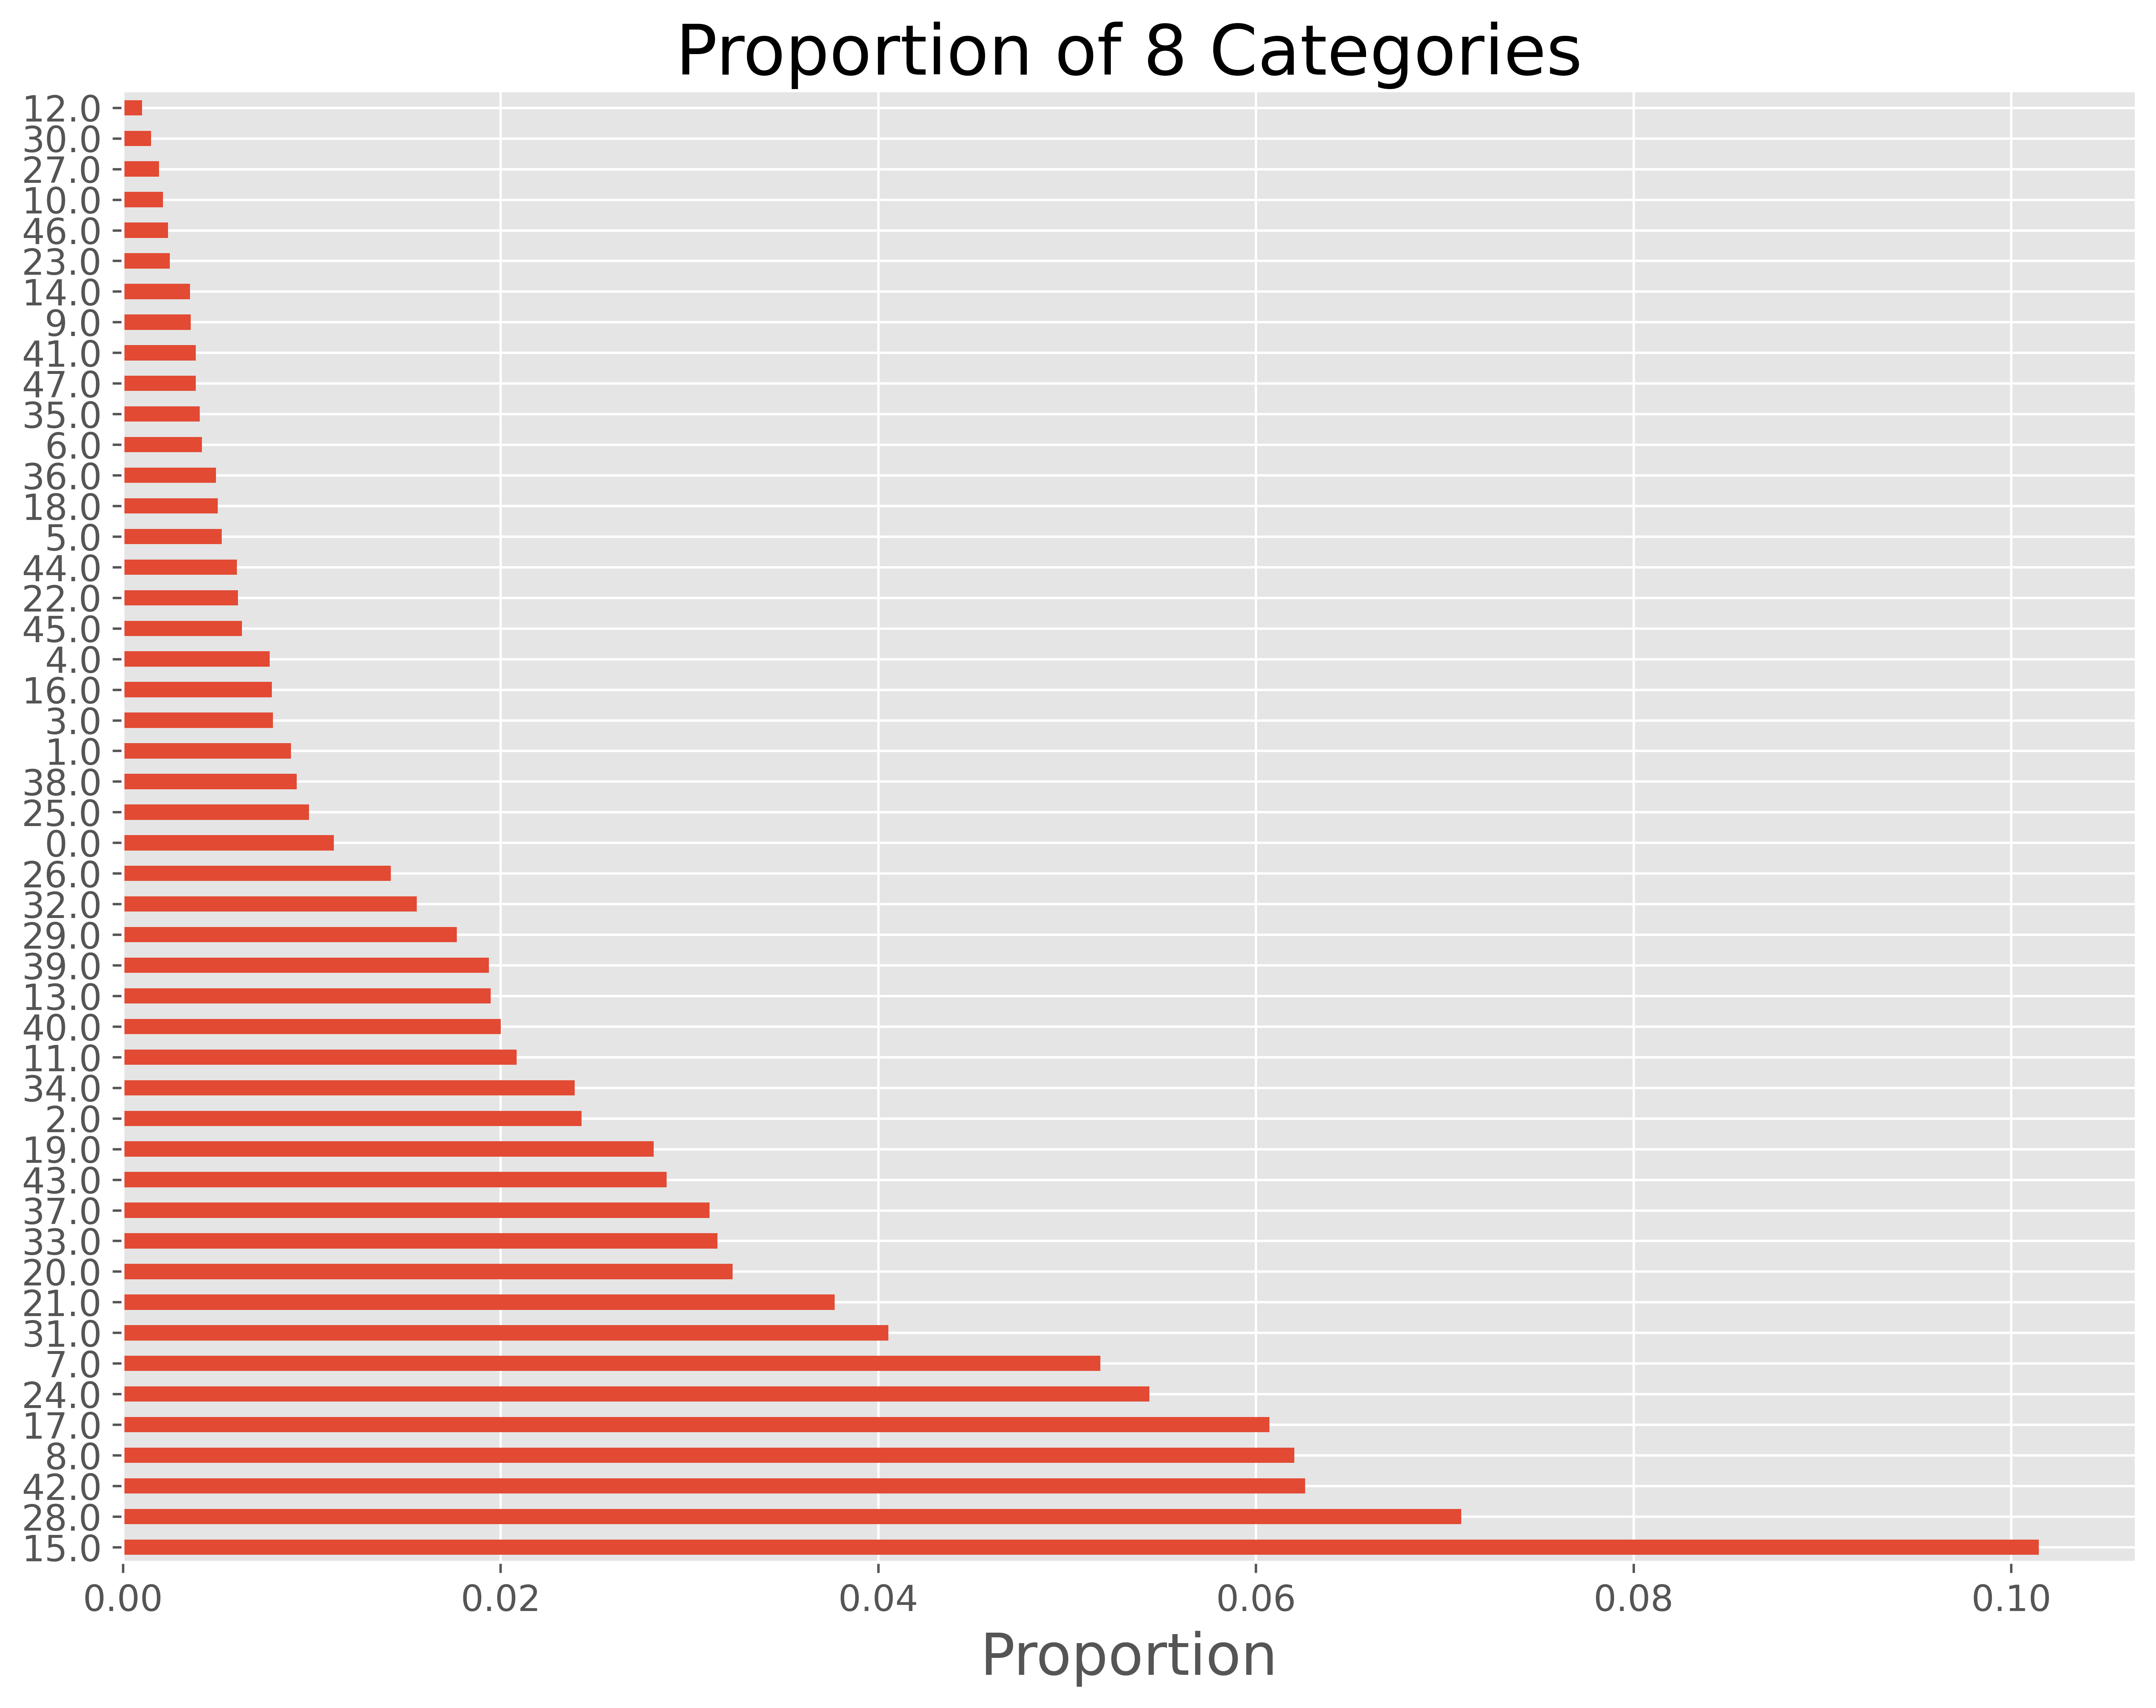

In [24]:
fig, ax = plt.subplots()

# Plot a normalized countplot
df['Category'].value_counts(normalize=True).plot.barh()

# Label
ax.set(title='Proportion of 8 Categories',
       xlabel='Proportion', ylabel='')

plt.show();


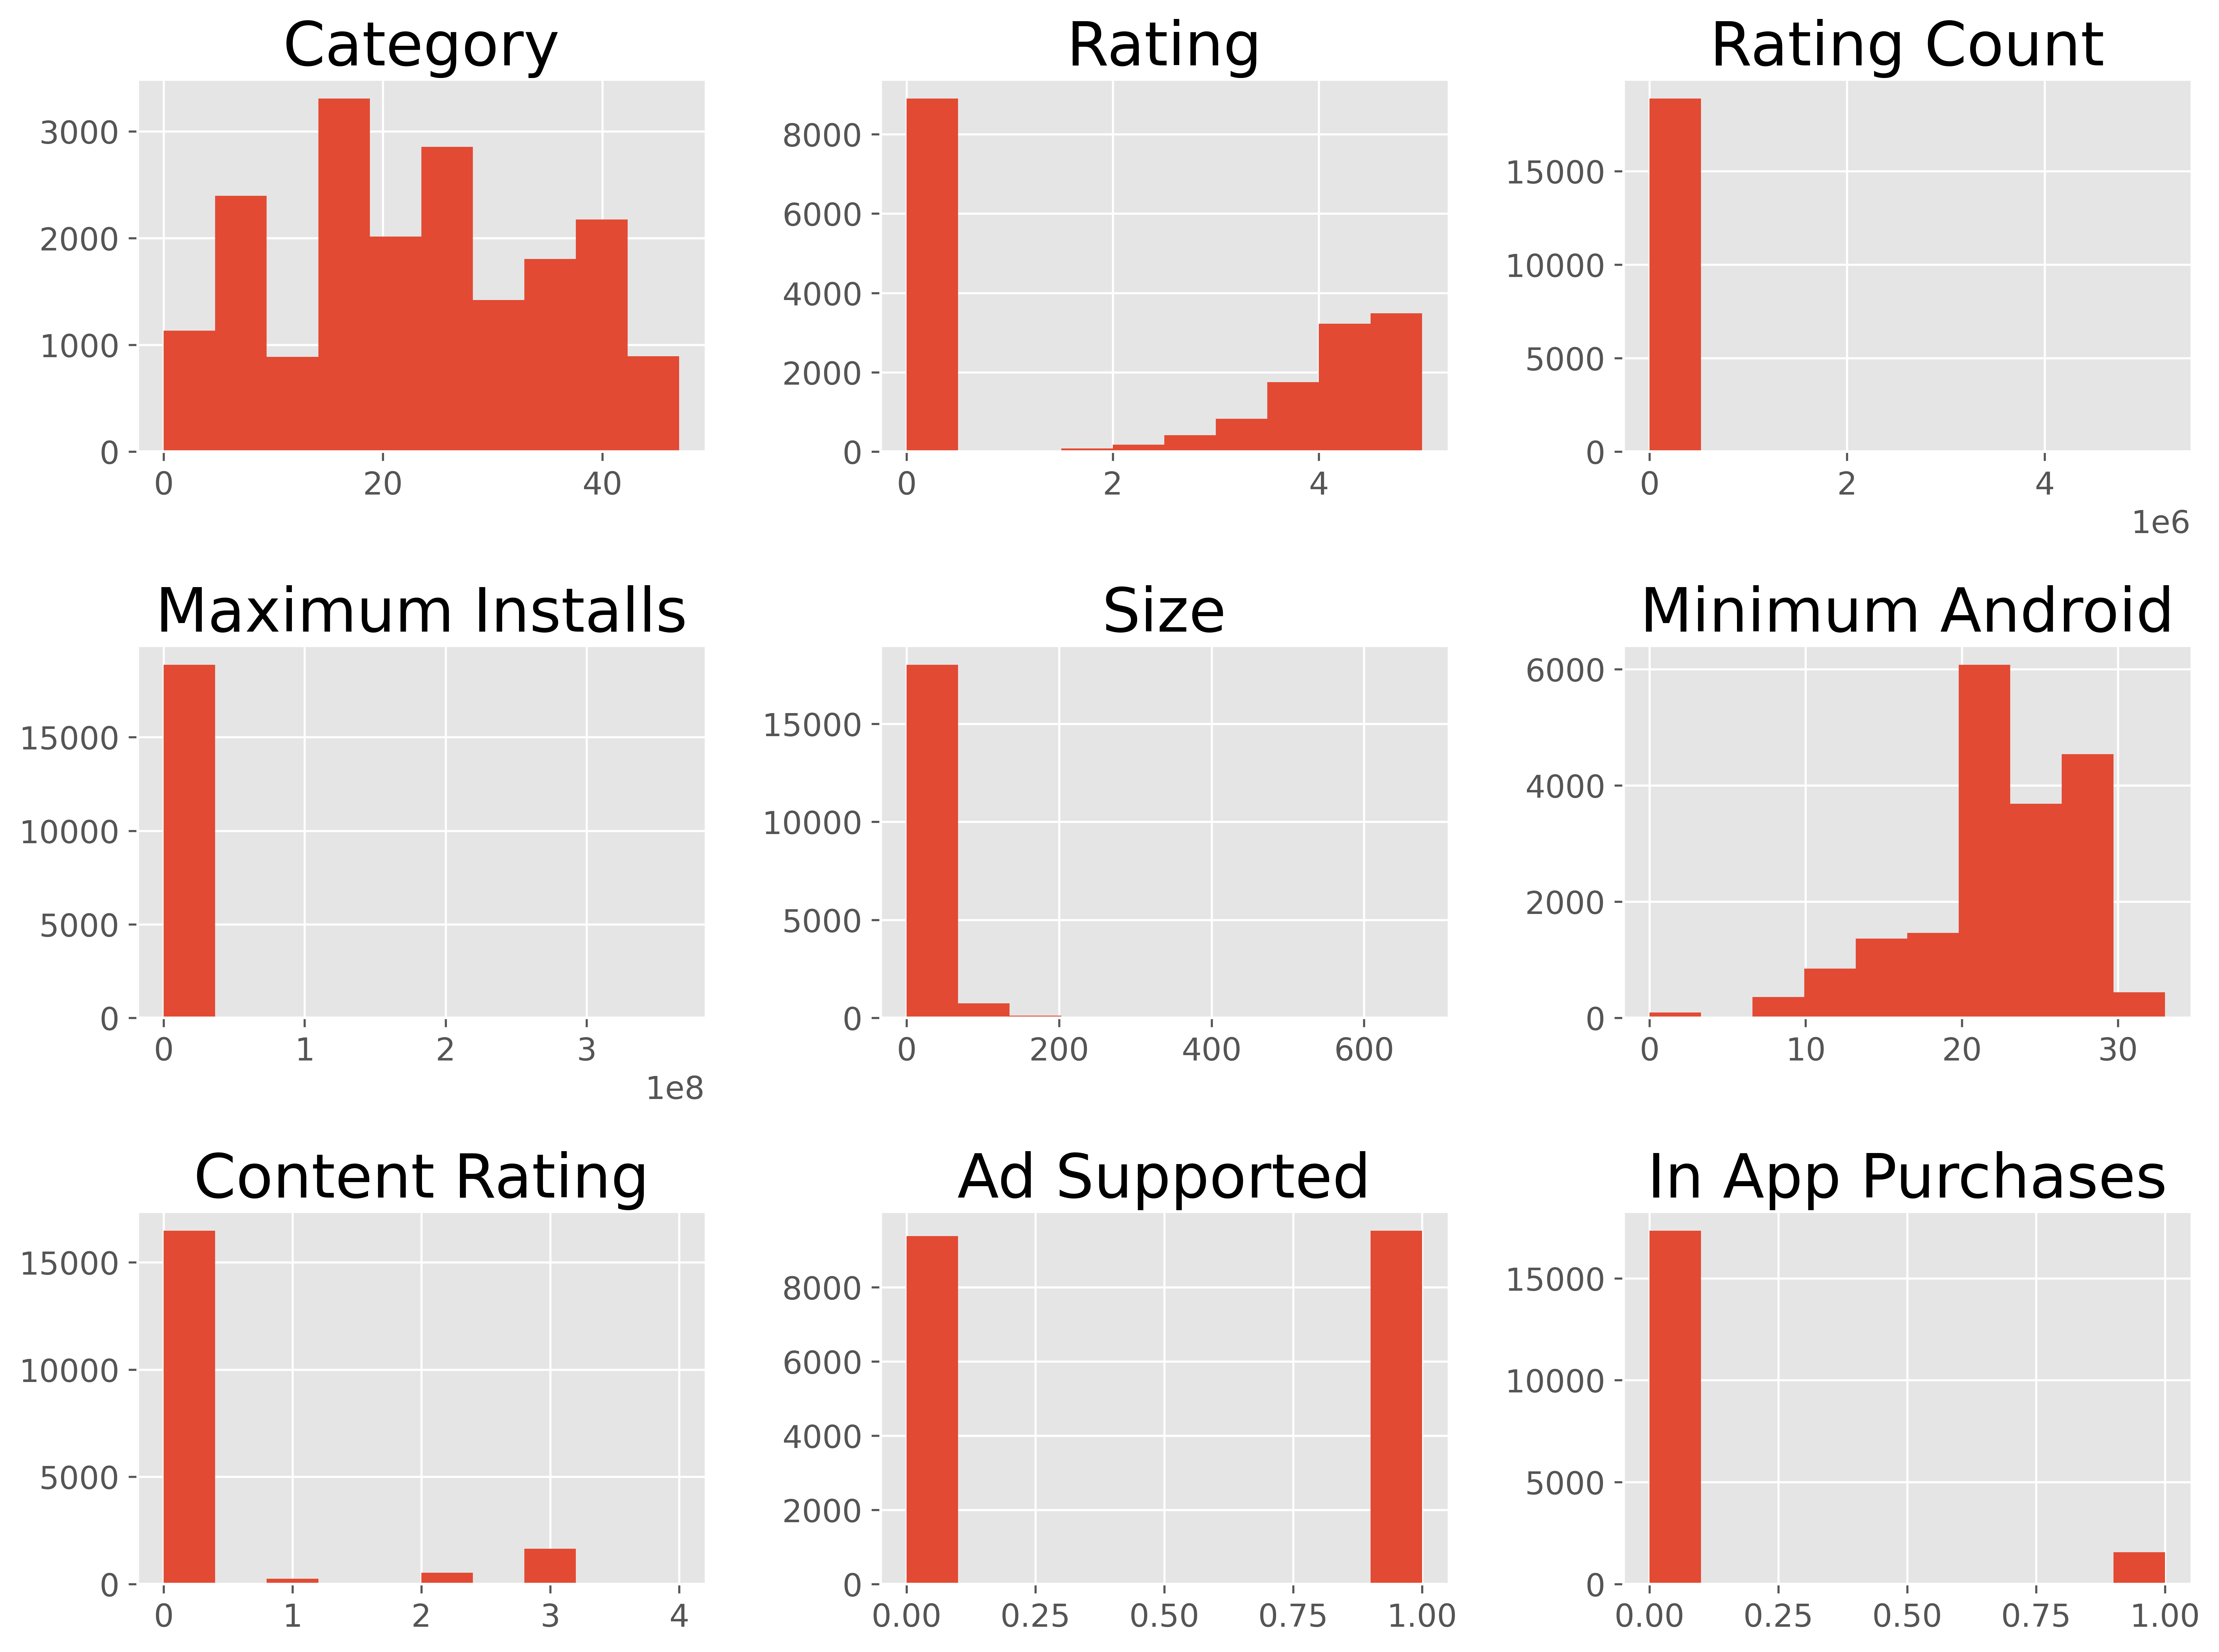

In [25]:
import matplotlib.pyplot as plt
import math

def make_subplot_layout(df, col_num):
    k = len(df.columns)
    row_num = math.ceil(k/col_num)
    for i in range(k) :
        plt.subplot(row_num,col_num,i+1)
        plt.hist(df.iloc[:,i])
        plt.title(df.columns[i])
    plt.tight_layout()
    plt.show()

make_subplot_layout(df.drop('Released', axis=1, inplace=False), 3)

In [8]:
es = ft.EntitySet(id='Store')
df["index"] = df.index

In [9]:
es.add_dataframe(dataframe_name="store_log",
                 dataframe=df,
                 index="index",
                 logical_types= {
                     "Ad Supported": Boolean,
                     "In App Purchases": Boolean,
                     "Category": Categorical,
                     "Minimum Android": Categorical
                 })

Entityset: Store
  DataFrames:
    store_log [Rows: 18893, Columns: 11]
  Relationships:
    No relationships

In [10]:
#Check dataset schema briefly
es["store_log"].ww.schema

,Logical Type,Semantic Tag(s)
Column,,
Category,Categorical,['category']
Rating,Double,['numeric']
Rating Count,Double,['numeric']
Maximum Installs,Integer,['numeric']
Size,Double,['numeric']
Minimum Android,Categorical,['category']
Released,Datetime,[]
Content Rating,Double,['numeric']
Ad Supported,Boolean,[]


In [11]:
pd.set_option('display.max_rows', 20)
ft.list_primitives()

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
0,any,aggregation,True,False,Determines if any value is 'True' in a list.,"<ColumnSchema (Logical Type = Boolean)>, <Colu...",None
1,mode,aggregation,False,False,Determines the most commonly repeated value.,<ColumnSchema (Semantic Tags = ['category'])>,None
2,count,aggregation,True,True,"Determines the total number of values, excludi...",<ColumnSchema (Semantic Tags = ['index'])>,None
3,first,aggregation,False,False,Determines the first value in a list.,<ColumnSchema>,None
4,skew,aggregation,False,False,Computes the extent to which a distribution di...,<ColumnSchema (Semantic Tags = ['numeric'])>,None
...,...,...,...,...,...,...,...
96,cum_max,transform,False,False,Calculates the cumulative maximum.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
97,modulo_numeric_scalar,transform,True,True,Return the modulo of each element in the list ...,<ColumnSchema (Semantic Tags = ['numeric'])>,None
98,not_equal_scalar,transform,True,True,Determines if values in a list are not equal t...,<ColumnSchema>,None
99,is_federal_holiday,transform,False,False,Determines if a given datetime is a federal ho...,<ColumnSchema (Logical Type = Datetime)>,None


In [12]:
'''

@Author: MinHyung Lee
@Since: 2022/05/23
새로운 feature(년, 월, 일)생성하기 위해 dfs 사용

'''


features, feature_names = ft.dfs(entityset=es,
                                 target_dataframe_name='store_log',
                                 trans_primitives=['year', 'month', 'day'])


In [13]:
feature_names

[<Feature: Category>,
 <Feature: Rating>,
 <Feature: Rating Count>,
 <Feature: Maximum Installs>,
 <Feature: Size>,
 <Feature: Minimum Android>,
 <Feature: Content Rating>,
 <Feature: Ad Supported>,
 <Feature: In App Purchases>,
 <Feature: DAY(Released)>,
 <Feature: MONTH(Released)>,
 <Feature: YEAR(Released)>]

In [14]:
df = features
df

,Category,Rating,Rating Count,Maximum Installs,Size,Minimum Android,Content Rating,Ad Supported,In App Purchases,DAY(Released),MONTH(Released),YEAR(Released)
index,,,,,,,,,,,,
0,26.0,4.9,20.0,552,5.8,27.0,0.0,True,False,5,3,2020
1,31.0,4.6,719.0,118989,12.0,21.0,0.0,True,False,24,3,2016
2,24.0,0.0,0.0,85,8.9,22.0,0.0,False,False,25,12,2018
3,11.0,0.0,0.0,723,27.0,27.0,0.0,True,False,18,4,2020
4,33.0,0.0,0.0,153,6.0,27.0,0.0,False,False,27,11,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,17.0,4.0,5.0,335,6.9,25.0,0.0,True,False,14,8,2018
19996,13.0,0.0,0.0,900,8.9,21.0,0.0,False,False,10,8,2017
19997,20.0,0.0,0.0,30,2.0,19.0,0.0,False,False,3,1,2020
